![logo](../LogoLine_horizon_C3S.png)

# Reproducing the single-system graphical products for additional variables

## Introduction

This Jupyter Notebook shows how the products shown in the C3S seasonal  __[graphical products](https://climate.copernicus.eu/charts/packages/c3s_seasonal/)__ can be calculated from data in the __[Climate Data Store](#configuration)__ (CDS), and plotted. The C3S seasonal graphical and data products are described in this __[documentation page](https://confluence.ecmwf.int/display/CKB/C3S+seasonal+forecast+product+descriptions)__. 

This example code can be used as the basis for creating graphical products which are not part of the C3S suite. In this example we look at monthly mean daily minimum temperature real-time forecasts (for one system, ECMWF System 51), which is a variable available in the CDS dataset but not the graphical products. A 'tercile summary' is computed from tercile probabilities. An ensemble mean anomaly is also calculated and plotted with significance testing applied. This will be used in a further example to create multi-system combinations.

1. [Configuration](#configuration)
2. [CDS API requests](#cds-api-requests)
3. [Load real-time forecast and hindcast data](#load-real-time-forecast-and-hindcast-data)
4. [Category based probability forecast product](#category-based-probability-forecast-product) 
5. [Deterministic forecast product](#deterministic-forecast-product)


## Configuration

Here we set which variable(s) will be downloaded, for which C3S seasonal system. We also set which real-time forecast date we will create a real-time forecast for, and which hindcast period to use (which will be used to calculate the terciles and anomalies). 

**Note that the URL and KEY need to be filled in with the details from your CDS account, and the [cdsapi package](https://cds.climate.copernicus.eu/how-to-api) needs to be installed.** Ideally, a `.cdsapirc` file should be created, to avoid the possibility of exposing credentials when sharing Notebooks. CDS API requests can now also be made using earthkit, as shown in [this example](https://earthkit-data.readthedocs.io/en/latest/examples/cds.html).

Import required modules and configure CDS API key and client.

In [2]:
# import required modules
import cdsapi
import os
import xarray as xr
import numpy as np
import pandas as pd

# Date and time related libraries
from dateutil.relativedelta import relativedelta
from calendar import monthrange
import datetime

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# config to avoid issues saving to netcdf if needed
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

URL = 'https://cds.climate.copernicus.eu/api'
KEY = '' # INSERT CDS KEY HERE IF NEEDED
c = cdsapi.Client(url=URL, key=KEY) # if a .cdsapirc file is used, url and key can be omitted

Define a library of provider details (seasonal forecast systems).

In [3]:
# library of C3S systems and useful parameters
# these are the latest system versions, as of January 2026
# max_hc and max_fc represent the number of members to be considered (the number index starts from 0, most recent first)
providers = {
    'ecmwf.s51': {'plot_name': 'ECMWF', 'plot_system': 'SEAS5', 'lagged': False},
    'meteo_france.s9': {'plot_name': 'Météo-France', 'plot_system': 'System 9', 'lagged': False},
    'ukmo.s604': {'plot_name': 'Met Office', 'plot_system': 'GloSea6', 'lagged': True, 'max_hc': 50, 'max_fc': 'none'},
    'dwd.s22': {'plot_name': 'DWD', 'plot_system': 'GCFS2.2', 'lagged': False},
    'cmcc.s4': {'plot_name': 'CMCC', 'plot_system': 'SPS4', 'lagged': False},
    'ncep.s2': {'plot_name': 'NCEP', 'plot_system': 'CFSv2', 'lagged': True, 'max_hc': 20, 'max_fc': 52},
    'jma.s3': {'plot_name': 'JMA', 'plot_system': 'CPS3', 'lagged': True, 'max_hc': 'none', 'max_fc': 55},
    'eccc.s4': {'plot_name': 'ECCC', 'plot_system': 'CanESM5.1p1bc', 'lagged': False},
    'eccc.s5': {'plot_name': 'ECCC', 'plot_system': 'GEM5.2-NEMO', 'lagged': False},
    'bom.s2': {'plot_name': 'BOM', 'plot_system': 'ACCESS-S2', 'lagged': False},
}

## CDS API requests

Here we request the desired hindcast and real-time forecast data in GRIB format using the CDS API, and save it within a 'data' folder in the current working directory, organized by originating centre and real-time forecast system. For this example, the CDS API keywords used are:

**Format**: `Grib` <br>
**Variable**: `minimum_2m_temperature_in_the_last_24_hours` *set via 'cds_var_name'* <br>
**Originating centre**: `ECMWF` *set via 'centre'* <br>
**System**: `51` *this refers to SEAS5 system 51, set via 'version'* <br>
**Product type**: `Monthly mean` *all ensemble members will be retrieved* <br>
**Year**: `1993 to 2016` *for the hindcast* `2024` *for the real-time forecast, set via 'hc_years' and 'fc_year'* <br>
**Month**: `02` *February, set via 'st_mon'* <br>
**Leadtime month**: `1 to 6` *all lead months available, February to July in this case*

Set some parameters for the request, and to be used later during plotting.

In [8]:
# select the system from the dictionary above
# and the associated fields needed for the CDS API request and loading the data
prov = 'ecmwf.s51'  
# split the string at '.s'
centre, version = prov.split('.s')
lagged = providers[prov]['lagged']

# define some other parameters for the data request
fc_yr = '2024' # the real-time forecast year
st_mon = '02' # the real-time forecast start month

# select a variable, tmin in this case
var = 'tmin'
var_str = 'daily mean T2m' # for plotting
var_cds_name = '2m_temperature'


lt_mons = [1, 2, 3, 4, 5, 6]  # cover all lead months when plotting month by month
hc_start = '1993'
hc_end = '2016'
hc_years = '_'.join([hc_start, hc_end])  # string to print the hindcast period, and label the file

# data path in cwd 
data_path = os.sep.join(['data', centre, version])
try:
   os.makedirs(data_path)
except FileExistsError:
   # directory already exists
   pass

Make the hindcast request and save the data.

In [ ]:
#HINDCAST REQUEST - 1993-2016
c.retrieve(
    'seasonal-monthly-single-levels',
    {
        'format': 'grib',
        'variable': var_cds_name,
        'originating_centre': centre,
        'system': version,
        'product_type': 'monthly_mean',
        'year': [
            '1993', '1994', '1995',
            '1996', '1997', '1998',
            '1999', '2000', '2001',
            '2002', '2003', '2004',
            '2005', '2006', '2007',
            '2008', '2009', '2010',
            '2011', '2012', '2013',
            '2014', '2015', '2016',
        ],
        'month': [st_mon],
        'leadtime_month': lt_mons
    },
    data_path + '/{}_mm_{}_{}_{}_{}.grib'.format(var, centre, version, hc_years, st_mon))

Make the real-time forecast request and save the data. 

In [ ]:
#FORECAST REQUEST
c.retrieve(
    'seasonal-monthly-single-levels',
    {
        'format': 'grib',
        'variable': [cds_var_name],
        'originating_centre': centre,
        'system': version,
        'product_type': 'monthly_mean',
        'year': [fc_yr],
        'month': [st_mon],
        'leadtime_month': lt_mons
    },
    data_path + '/{}_mm_{}_{}_{}_{}.grib'.format(var, centre, version, fc_yr, st_mon))

## Load real-time forecast and hindcast data



First, prepare for the lagged start time coordinates, where careful treatment is required when loading the data into xarray. Some of the seasonal forecast monthly data on the CDS comes from systems using members initialized on different start dates (lagged start date ensembles). In the GRIB encoding used for those systems we will therefore have two different xarray/cfgrib keywords for the real start date of each member (`time`) and for the nominal start date (`indexing_time`) which is the one we would need to use for those systems initializing their members with a lagged start date approach. 

In [5]:
# For the re-shaping of time coordinates in xarray.Dataset we need to select the right one 
#  -> burst mode ensembles (e.g. ECMWF SEAS5) use "time". 
#  -> lagged start ensembles (e.g. MetOffice GloSea6) use "indexing_time" (see documentation about nominal start date)
if lagged:
    st_dim_name = 'indexing_time'
else:
    st_dim_name = 'time'

Now load the hindcast data as an xarray object using `cfgrib` ([link](https://github.com/ecmwf/cfgrib)), and inspect it.

In [9]:
# load hindcasts
hc_path = data_path + '/' + '_'.join([var, 'mm', centre, version, hc_years, st_mon]) + '.grib'
hcst = xr.open_dataarray(hc_path, engine='cfgrib',
                         backend_kwargs=dict(time_dims=('forecastMonth', st_dim_name)))
# rename indexing time or time to start date
hcst = hcst.rename({st_dim_name: 'start_date', 'longitude': 'lon', 'latitude': 'lat'})
# roll longitude
hcst = hcst.assign_coords(lon=(((hcst.lon + 180) % 360) - 180)).sortby('lon')
hcst

<xarray.DataArray 'mn2t24' (number: 25, forecastMonth: 6, start_date: 24,
                            lat: 180, lon: 360)> Size: 933MB
[233280000 values with dtype=float32]
Coordinates:
  * number         (number) int64 200B 0 1 2 3 4 5 6 7 ... 18 19 20 21 22 23 24
  * forecastMonth  (forecastMonth) int64 48B 1 2 3 4 5 6
  * start_date     (start_date) datetime64[ns] 192B 1993-02-01 ... 2016-02-01
    surface        float64 8B ...
  * lat            (lat) float64 1kB 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * lon            (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Attributes: (12/31)
    GRIB_paramId:                             52
    GRIB_dataType:                            fcmean
    GRIB_numberOfPoints:                      64800
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           mn2t24
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                Minimum temperature at 2 metres...
    units:                                    K
    standard_name:                            unknown

Now load the real-time forecast data in the same manner.

In [10]:
fc_path = data_path + '/' + '_'.join([var, 'mm', centre, version, fc_yr, st_mon]) + '.grib'
fcst = xr.open_dataarray(fc_path, engine='cfgrib',
                         backend_kwargs=dict(time_dims=('forecastMonth', st_dim_name)))
# rename indexing time or time to start date
fcst = fcst.rename({st_dim_name: 'start_date', 'longitude': 'lon', 'latitude': 'lat'})
# roll longitude
fcst = fcst.assign_coords(lon=(((fcst.lon + 180) % 360) - 180)).sortby('lon')
fcst

<xarray.DataArray 'mn2t24' (number: 51, forecastMonth: 6, lat: 180, lon: 360)> Size: 79MB
[19828800 values with dtype=float32]
Coordinates:
  * number         (number) int64 408B 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 48B 1 2 3 4 5 6
    start_date     datetime64[ns] 8B ...
    surface        float64 8B ...
  * lat            (lat) float64 1kB 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * lon            (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Attributes: (12/31)
    GRIB_paramId:                             52
    GRIB_dataType:                            fcmean
    GRIB_numberOfPoints:                      64800
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           mn2t24
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                Minimum temperature at 2 metres...
    units:                                    K
    standard_name:                            unknown

For the real-time forecast array, add a 'valid time' coordinate, which will be useful for labeling the plots later.

In [11]:
valid_time = [pd.to_datetime(fcst.start_date.values) + relativedelta(months=fcmonth-1) for fcmonth in fcst.forecastMonth]
fcst = fcst.assign_coords(valid_time=('forecastMonth',valid_time))
fcst

<xarray.DataArray 'mn2t24' (number: 51, forecastMonth: 6, lat: 180, lon: 360)> Size: 79MB
[19828800 values with dtype=float32]
Coordinates:
  * number         (number) int64 408B 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 48B 1 2 3 4 5 6
    start_date     datetime64[ns] 8B 2024-02-01
    surface        float64 8B ...
  * lat            (lat) float64 1kB 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * lon            (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    valid_time     (forecastMonth) datetime64[ns] 48B 2024-02-01 ... 2024-07-01
Attributes: (12/31)
    GRIB_paramId:                             52
    GRIB_dataType:                            fcmean
    GRIB_numberOfPoints:                      64800
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           mn2t24
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                Minimum temperature at 2 metres...
    units:                                    K
    standard_name:                            unknown

### Select ensemble members

Here select which ensemble members to use. For some lagged start systems a subset of the available ensemble members are used in the graphical products, as described in the __[documentation](https://confluence.ecmwf.int/display/CKB/Summary+of+available+data#:~:text=per%20forecast%20system-,Nominal%20Start%20Dates,-For%20systems%20with)__.

In [12]:
# for some lagged systems sub-select 'qualifying' ensemble members used in the C3S graphical products
if lagged:
    max_hc = providers[prov]['max_hc']
    max_fc = providers[prov]['max_fc']
    if isinstance(max_hc, int):
        hcst = hcst.sel(number=slice(None, max_hc-1))
    if isinstance(max_fc, int):
        fcst = fcst.sel(number=slice(None, max_fc-1))

## Category based probability forecast product

### Calculate tercile boundaries

The first step of calculating probabilities for the tercile summary is to calculate the terciles from the hindcast period.

In [13]:
quantiles = [1. / 3., 2. / 3.]
hcst_qbnds = hcst.quantile(quantiles, ['start_date', 'number'])
hcst_qbnds

<xarray.DataArray 'mn2t24' (quantile: 2, forecastMonth: 6, lat: 180, lon: 360)> Size: 6MB
array([[[[244.33795675, 244.3340505 , 244.3294932 , ..., 244.33822123,
          244.34056091, 244.33990987],
         [244.26223246, 244.2658844 , 244.26529948, ..., 244.26017761,
          244.26213074, 244.26158142],
         [244.3015035 , 244.29098002, 244.28975423, ..., 244.33988444,
          244.32062276, 244.30947367],
         ...,
         [237.04042562, 237.21615092, 237.3900706 , ..., 236.69554647,
          236.79473877, 236.89592997],
         [234.16823832, 234.20966085, 234.24293518, ..., 234.05273946,
          234.08274333, 234.1269633 ],
         [233.24236552, 233.25799052, 233.27361552, ..., 233.18774923,
          233.20597839, 233.22408549]],

        [[245.56556702, 245.55254618, 245.53952535, ..., 245.58742269,
          245.58509827, 245.57663472],
         [245.5316925 , 245.52070109, 245.51565043, ..., 245.57148743,
          245.5621287 , 245.5460968 ],
         [245.55889893, 245.56478373, 245.53250122, ..., 245.61849467,
          245.59778849, 245.57480876],
...
         [225.34759521, 225.58892822, 225.82394918, ..., 224.80664062,
          224.97796631, 225.15042114],
         [221.08680725, 221.15615845, 221.21076457, ..., 220.89515177,
          220.96019491, 221.0200297 ],
         [219.65723165, 219.67907206, 219.70055644, ..., 219.59383647,
          219.61271667, 219.63448588]],

        [[273.45979818, 273.46118164, 273.46191406, ..., 273.46000163,
          273.45887248, 273.45979818],
         [273.48677572, 273.48613485, 273.48429362, ..., 273.49622599,
          273.49405924, 273.48976644],
         [273.51208496, 273.50508626, 273.49625651, ..., 273.52081299,
          273.5201416 , 273.51790365],
         ...,
         [223.76084391, 224.02160136, 224.28734843, ..., 223.19769287,
          223.36869812, 223.53948975],
         [219.58465068, 219.65275574, 219.71683757, ..., 219.36538696,
          219.4367218 , 219.5164388 ],
         [218.15458171, 218.16595459, 218.1831665 , ..., 218.1204834 ,
          218.13516235, 218.14623006]]]])
Coordinates:
  * forecastMonth  (forecastMonth) int64 48B 1 2 3 4 5 6
  * lat            (lat) float64 1kB 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * lon            (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * quantile       (quantile) float64 16B 0.3333 0.6667

### Compute real-time forecast probabilities

Now calculate the real-time forecast probabilities by counting the number of ensemble members above and below the upper and lower terciles.

In [14]:
fc_ens = fcst.sizes['number']
print(" ####### FC ENS SIZE ####### ")
print(fc_ens)
above = fcst.where(fcst > hcst_qbnds.sel(quantile=2. / 3.)).count('number')
below = fcst.where(fcst < hcst_qbnds.sel(quantile=1. / 3.)).count('number')

 ####### FC ENS SIZE ####### 
51


Now calculate probabilities for each tercile category (above, below, and normal), and combine them to create a single array to use for plotting the tercile summary.

In [15]:
P_above = 100. * (above / float(fc_ens))
P_below = 100. * (below / float(fc_ens))
P_normal = 100. - (P_above + P_below)

a = P_above.where(P_above > np.maximum(40. + 0 * P_above, P_below), 0.)
b = P_below.where(P_below > np.maximum(40. + 0 * P_below, P_above), 0.)
P_summary = a - b

P_summary

<xarray.DataArray 'mn2t24' (forecastMonth: 6, lat: 180, lon: 360)> Size: 3MB
array([[[100.        , 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ],
        [100.        , 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ],
        [100.        , 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ],
        ...,
        [ 58.82352941,  58.82352941,  58.82352941, ...,  56.8627451 ,
          56.8627451 ,  58.82352941],
        [ 62.74509804,  62.74509804,  62.74509804, ...,  64.70588235,
          64.70588235,  62.74509804],
        [ 52.94117647,  52.94117647,  52.94117647, ...,  52.94117647,
          52.94117647,  52.94117647]],

       [[ 72.54901961,  72.54901961,  72.54901961, ...,  72.54901961,
          72.54901961,  72.54901961],
        [ 78.43137255,  78.43137255,  78.43137255, ...,  80.39215686,
          80.39215686,  78.43137255],
        [ 76.47058824,  76.47058824,  76.47058824, ...,  76.47058824,
          76.47058824,  76.47058824],
...
        [ 47.05882353,  50.98039216,  49.01960784, ...,  49.01960784,
          47.05882353,  47.05882353],
        [ 50.98039216,  49.01960784,  49.01960784, ...,  49.01960784,
          49.01960784,  50.98039216],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [ 41.17647059,   0.        ,  41.17647059, ...,   0.        ,
           0.        ,  41.17647059],
        ...,
        [ 50.98039216,  50.98039216,  52.94117647, ...,  50.98039216,
          50.98039216,  50.98039216],
        [ 54.90196078,  54.90196078,  56.8627451 , ...,  56.8627451 ,
          56.8627451 ,  56.8627451 ],
        [ 49.01960784,  49.01960784,  49.01960784, ...,  49.01960784,
          49.01960784,  49.01960784]]])
Coordinates:
  * forecastMonth  (forecastMonth) int64 48B 1 2 3 4 5 6
    start_date     datetime64[ns] 8B 2024-02-01
    surface        float64 8B 0.0
  * lat            (lat) float64 1kB 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * lon            (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    valid_time     (forecastMonth) datetime64[ns] 48B 2024-02-01 ... 2024-07-01

### Plot tercile summary

Here set up a directory for saving the plots, and set up some plot parameters.

In [16]:
# levels to use when shading the plot, and corresponding colours
contour_levels = [-100., -70., -60., -50., -40., 40., 50., 60., 70., 100.]
contour_colours = ["navy", "blue", "deepskyblue", "cyan", "white", "yellow", "orange", "orangered", "tab:red"]

Reproduce the [C3S seasonal charts](https://climate.copernicus.eu/charts/packages/c3s_seasonal/) tercile summary plot, which shows if either the upper or lower category has a probability which exceeds 40%. The white areas of the plot mean either that the middle category is the most probable, or that all categories have similar probabilities. The plot is also explained in the chart caption, and the corresponding description in [the C3S seasonal product descriptions page](https://confluence.ecmwf.int/display/CKB/C3S+seasonal+forecast+product+descriptions). 

Note: the C3S graphical products are contour plots rather than the grid mesh plots below.

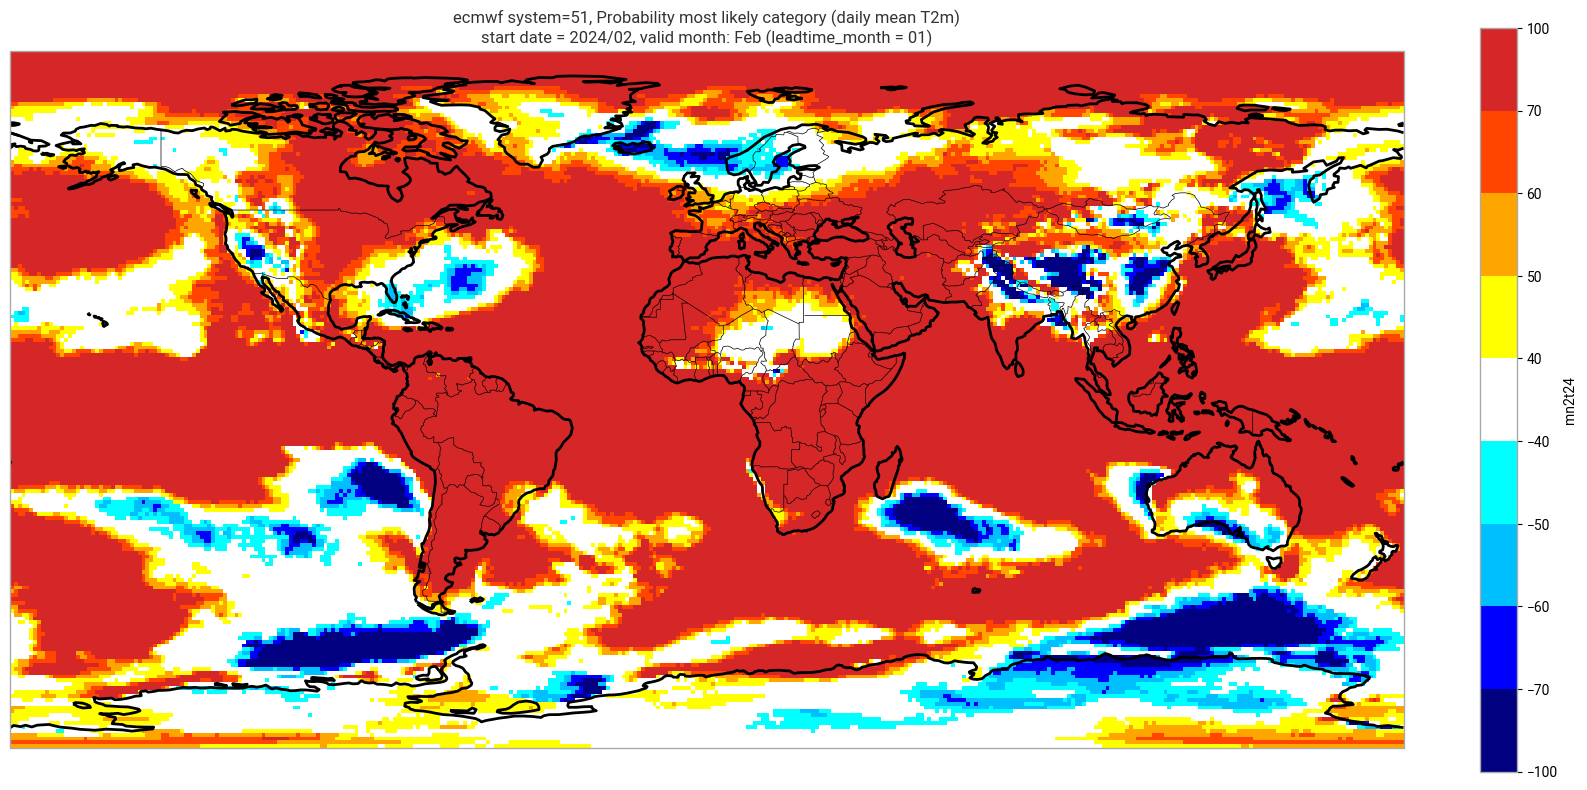

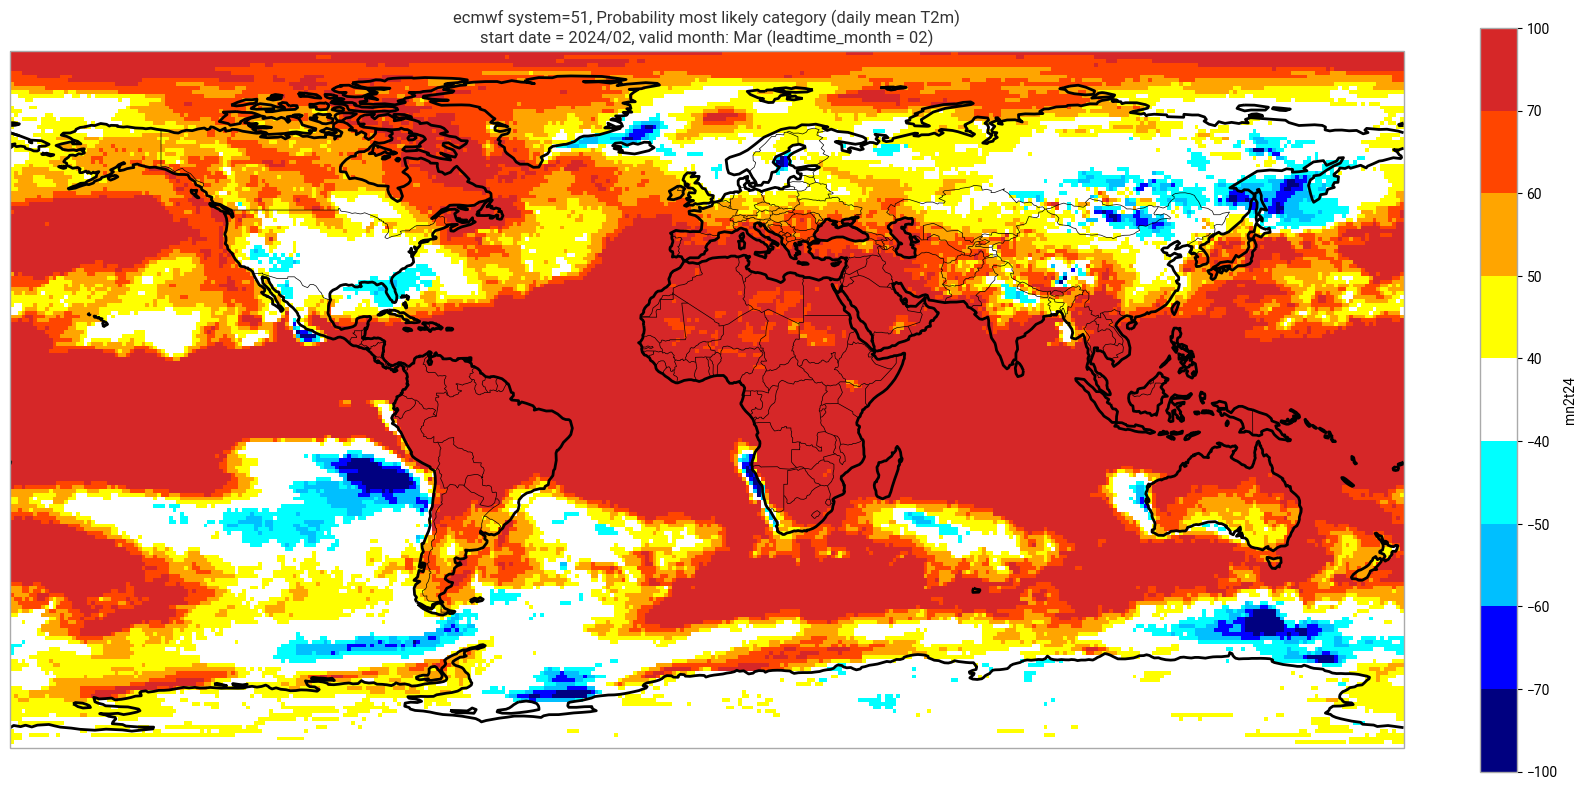

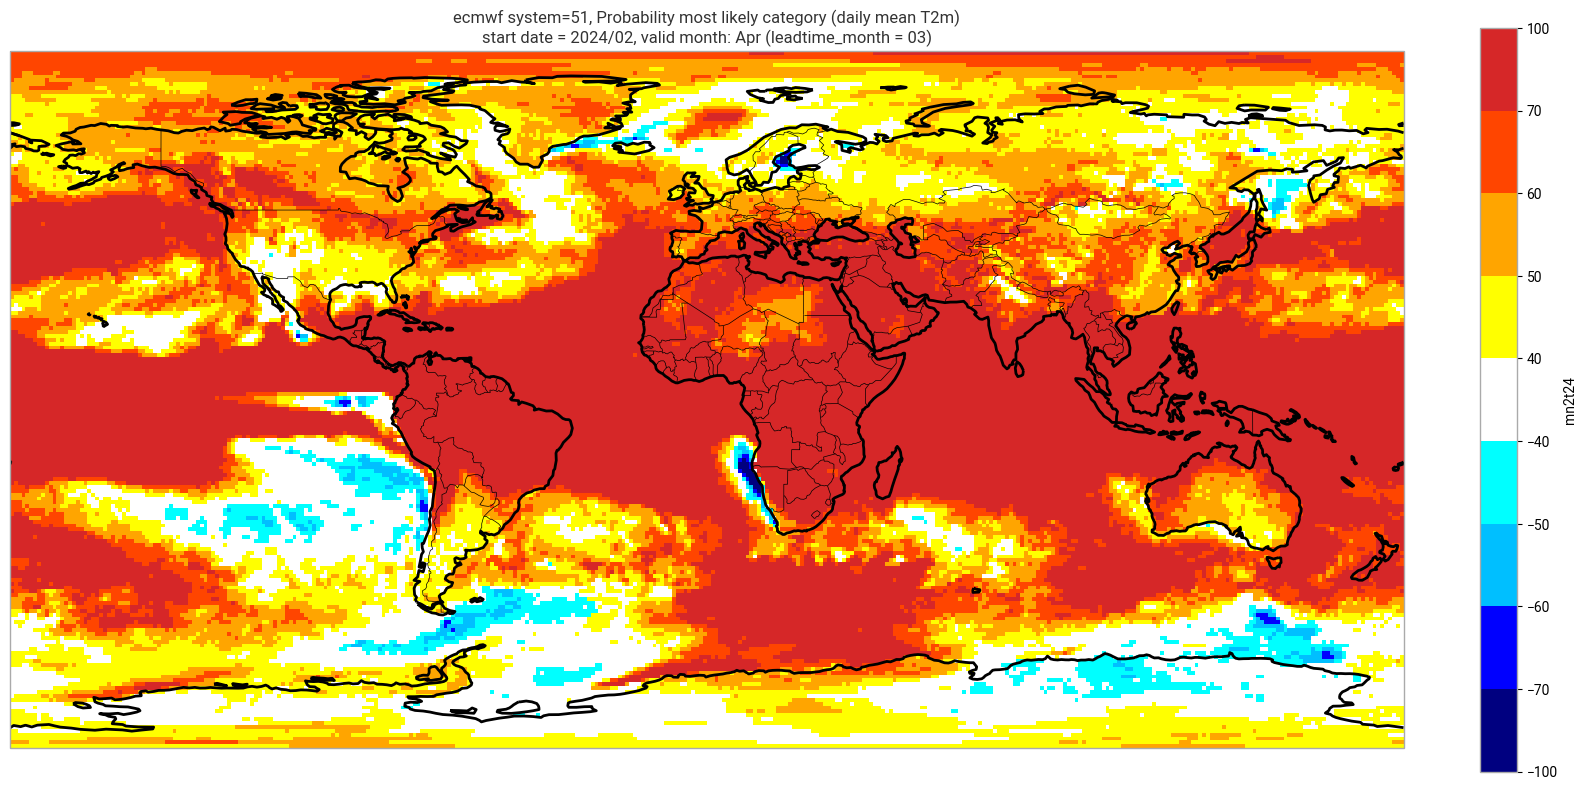

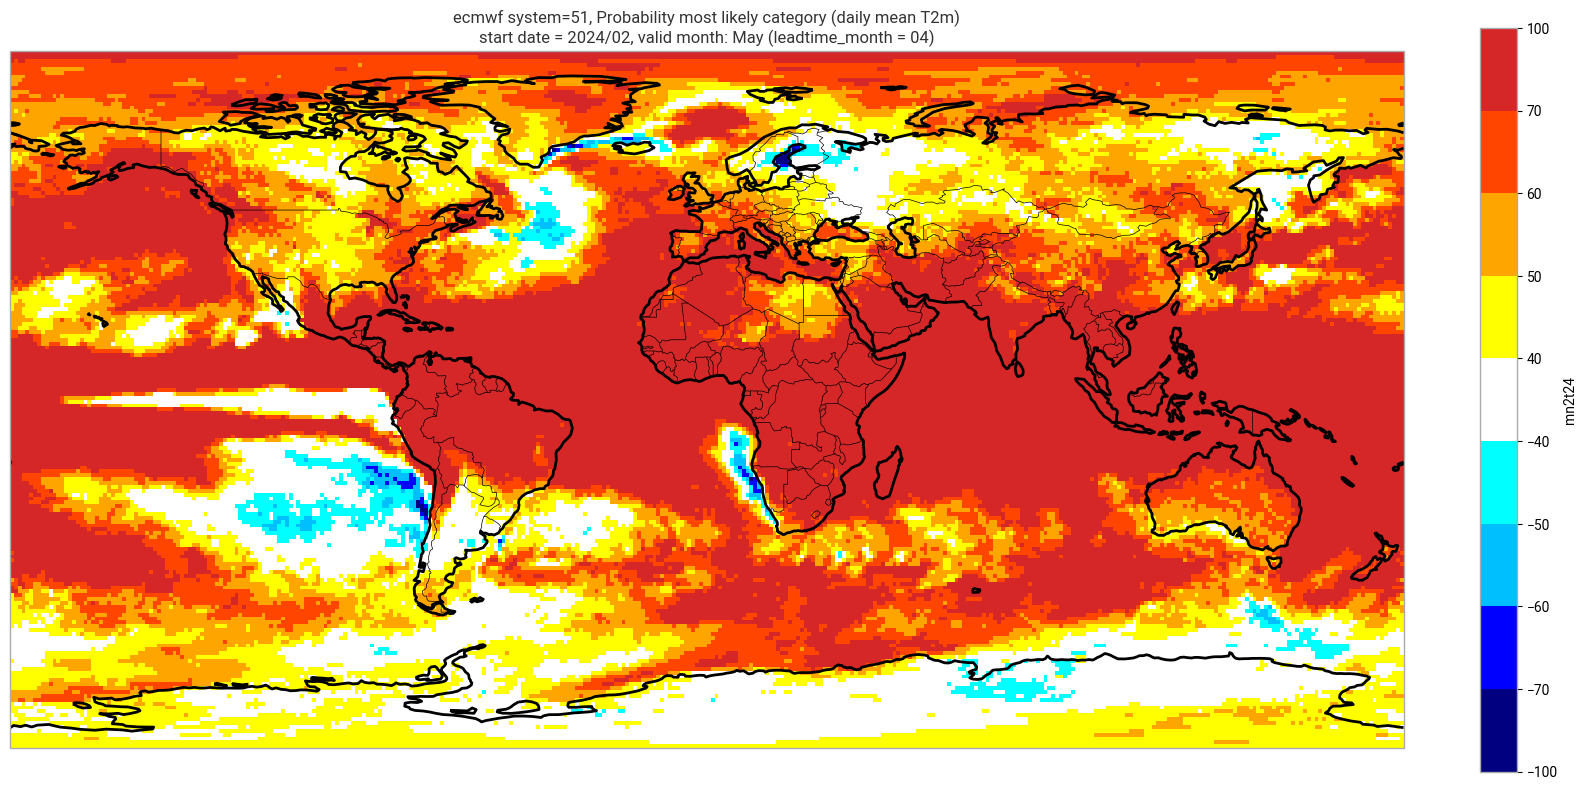

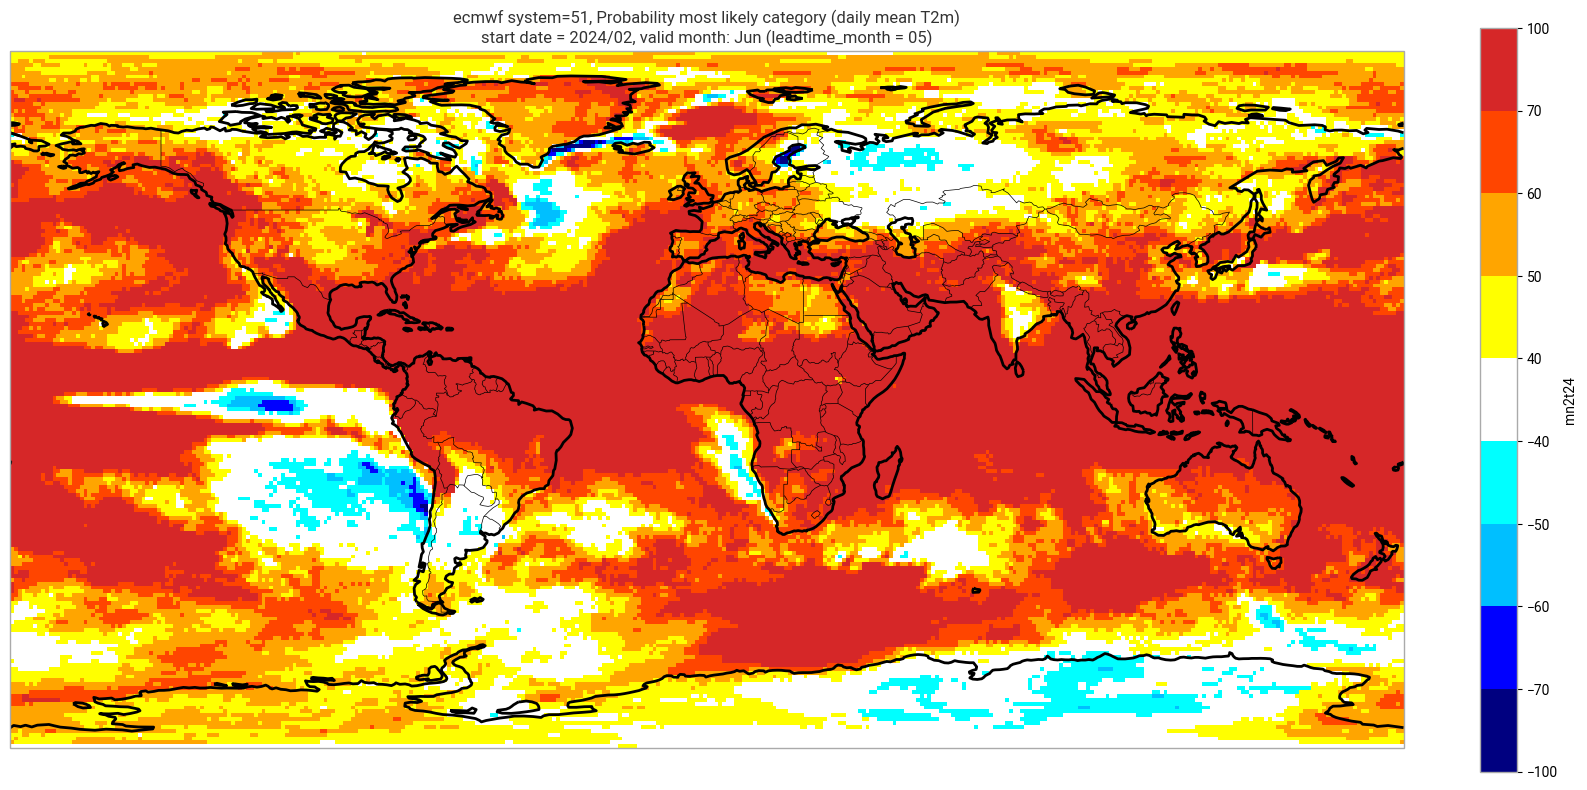

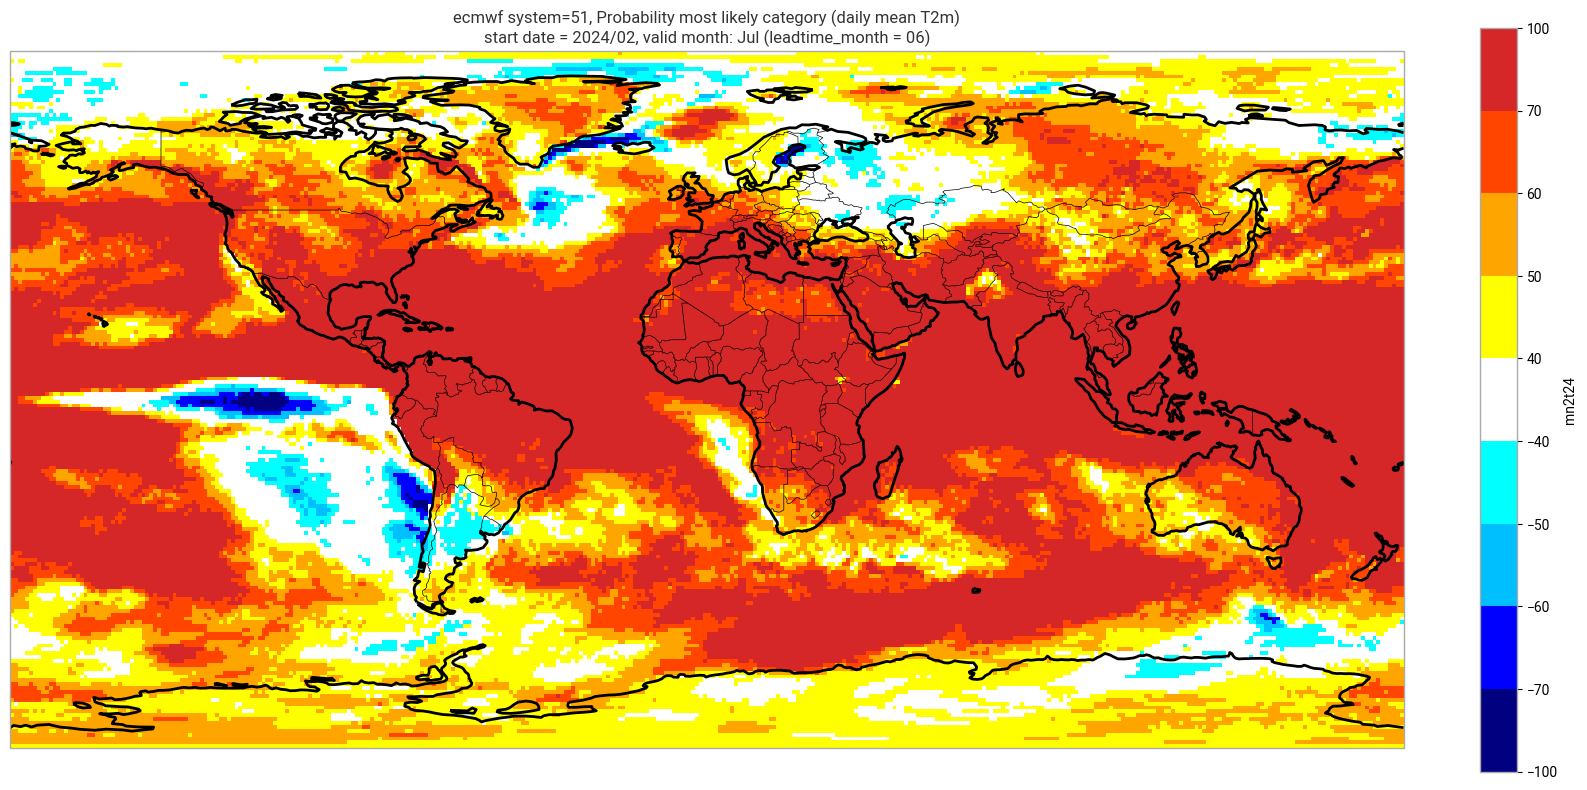

In [17]:
for ltm in lt_mons:
    lt_str = str(ltm).zfill(2)
    plot_data = P_summary.sel(forecastMonth=ltm)  # extract the specific real-time forecast month

    # clip the data to sit within levels range
    plot_data = plot_data.clip(min=-99, max=99)
    
    valid_time = pd.to_datetime(plot_data.valid_time.values)
    vm_str = valid_time.strftime('%b')  # valid month string to label the plot
    title_txt1 = '{} system={}'.format(centre, version) + ', Probability most likely category ({})'.format(var_str)
    title_txt2 = 'start date = {}/{}, valid month: {} (leadtime_month = {})'.format(fc_yr, st_mon, vm_str, lt_str)

    fig = plt.figure(figsize=(16, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.)
    plot_data.plot(levels=contour_levels, colors=contour_colours,
                                               cbar_kwargs={'fraction': 0.033, 'extend': 'neither'})
    plt.title(title_txt1 + '\n' + title_txt2)
    plt.tight_layout()


## Deterministic forecast product

### Compute ensemble mean real-time forecast anomaly
Calculate the ensemble mean anomaly using the real-time forecast array and the hindcast array.

In [18]:
hcst_clim = hcst.mean(['start_date', 'number'])  # mean climatology, over start years and ensemble members, for each lead time for the chosen start month
fcst_anom = fcst - hcst_clim
fcst_anom_mean = fcst_anom.mean(['number'])
fcst_anom_mean

<xarray.DataArray 'mn2t24' (forecastMonth: 6, lat: 180, lon: 360)> Size: 2MB
array([[[ 5.8435555e+00,  5.8450460e+00,  5.8465314e+00, ...,
          5.8408370e+00,  5.8414240e+00,  5.8425221e+00],
        [ 5.4541602e+00,  5.4562454e+00,  5.4582152e+00, ...,
          5.4545054e+00,  5.4540286e+00,  5.4533906e+00],
        [ 5.0837092e+00,  5.0856071e+00,  5.0871773e+00, ...,
          5.0727205e+00,  5.0768476e+00,  5.0810809e+00],
        ...,
        [ 9.9170518e-01,  9.8062819e-01,  9.6966404e-01, ...,
          1.0054405e+00,  1.0021384e+00,  9.9881130e-01],
        [ 1.0190047e+00,  1.0174112e+00,  1.0153345e+00, ...,
          1.0173968e+00,  1.0182438e+00,  1.0192608e+00],
        [ 7.2599494e-01,  7.2523648e-01,  7.2437811e-01, ...,
          7.2827595e-01,  7.2749209e-01,  7.2671747e-01]],

       [[ 1.9410343e+00,  1.9393972e+00,  1.9372257e+00, ...,
          1.9482039e+00,  1.9457873e+00,  1.9431790e+00],
        [ 1.8530002e+00,  1.8510718e+00,  1.8492428e+00, ...,
          1.8631986e+00,  1.8595988e+00,  1.8559983e+00],
        [ 1.7578406e+00,  1.7582200e+00,  1.7586147e+00, ...,
          1.7612247e+00,  1.7600017e+00,  1.7583729e+00],
...
        [ 7.9657310e-01,  7.9393393e-01,  7.9108202e-01, ...,
          8.1358725e-01,  8.0704784e-01,  8.0105323e-01],
        [ 6.7678535e-01,  6.7725748e-01,  6.7815447e-01, ...,
          6.6916311e-01,  6.7202818e-01,  6.7478347e-01],
        [ 1.8580657e-01,  1.8689564e-01,  1.8812890e-01, ...,
          1.7871693e-01,  1.8133694e-01,  1.8391927e-01]],

       [[-8.5239783e-03, -8.7878658e-03, -8.8608684e-03, ...,
         -8.0668135e-03, -8.0931420e-03, -8.5167978e-03],
        [-4.0193447e-03, -3.8577809e-03, -4.0175496e-03, ...,
         -3.9086435e-03, -3.7446863e-03, -3.8948806e-03],
        [ 8.3330944e-03,  7.9872282e-03,  7.4732164e-03, ...,
          7.7562518e-03,  8.1266519e-03,  8.4964531e-03],
        ...,
        [ 9.7999066e-01,  9.8089659e-01,  9.8171008e-01, ...,
          9.8080772e-01,  9.8052770e-01,  9.7991407e-01],
        [ 9.5288926e-01,  9.5017076e-01,  9.4739515e-01, ...,
          9.5606816e-01,  9.5519930e-01,  9.5465595e-01],
        [ 7.5614029e-01,  7.5459200e-01,  7.5353193e-01, ...,
          7.5940627e-01,  7.5804853e-01,  7.5703609e-01]]], dtype=float32)
Coordinates:
  * forecastMonth  (forecastMonth) int64 48B 1 2 3 4 5 6
    start_date     datetime64[ns] 8B 2024-02-01
    surface        float64 8B 0.0
  * lat            (lat) float64 1kB 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * lon            (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    valid_time     (forecastMonth) datetime64[ns] 48B 2024-02-01 ... 2024-07-01

Save the ensemble mean anomaly for possible future use.

In [19]:
save_name = '_'.join([var, centre, version, fc_yr, st_mon, 'ensmean_anom.nc'])
fcst_anom_mean.to_netcdf(os.sep.join([data_path, save_name]))

### Plot ensemble mean anomaly

Note, the level values will need to be updated for variables other than Tmin/Tmax/Tmean.

In [20]:
contour_levels = [-2., -1.5, -1., -0.5, -0.2, 0.2, 0.5, 1.0, 1.5, 2.0]
contour_colours = ["navy", "blue", "deepskyblue", "cyan", "white", "yellow", "orange", "orangered", "tab:red"]
# clip the data to -2 and 2
fcst_anom_mean = fcst_anom_mean.clip(min=-1.99, max=1.99)

### Make a basic plot for one lead month

We plot the ensemble mean anomaly for the first real-time forecast month. Here no significance testing is applied, this will be added in the next step, so this plot is just to demonstrate the difference this makes. 

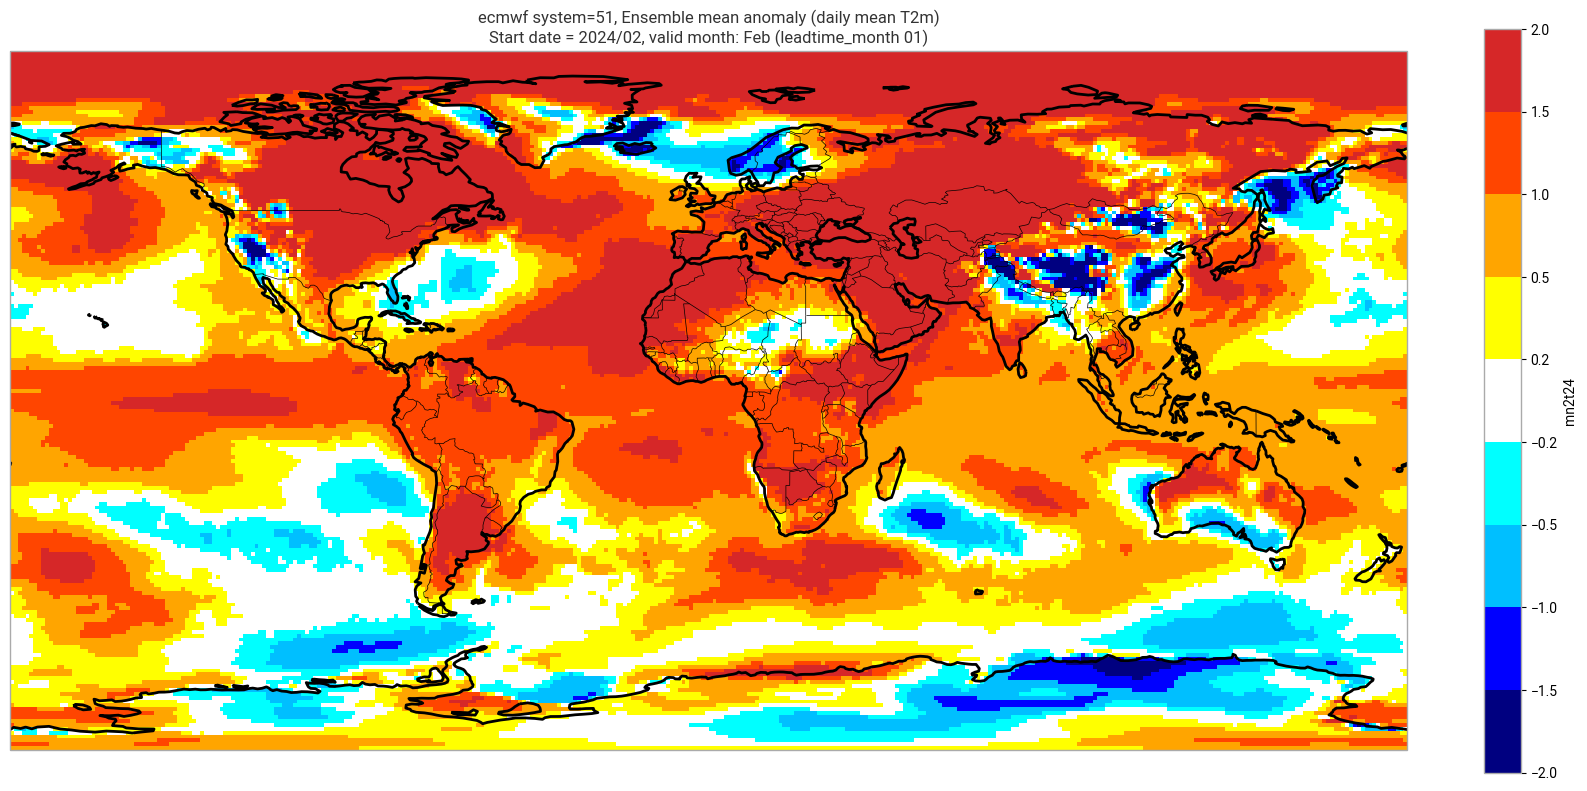

In [21]:
ltm = 1 
lt_str = str(ltm).zfill(2)
plot_data = fcst_anom_mean.sel(forecastMonth=ltm)  # extract the specific real-time forecast month

valid_time = pd.to_datetime(plot_data.valid_time.values)
vm_str = valid_time.strftime('%b')  # valid month string to label the plot
title_txt1 = '{} system={}'.format(centre, version) + ', Ensemble mean anomaly ({})'.format(var_str)
title_txt2 = 'Start date = {}/{}, valid month: {} (leadtime_month {})'.format(fc_yr, st_mon, vm_str, lt_str)

fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.)
plot_data.plot(levels=contour_levels, colors=contour_colours,
                                           cbar_kwargs={'fraction': 0.033, 'extend': 'neither'})
plt.title(title_txt1 + '\n' + title_txt2)
plt.tight_layout()

### Add significance contours and masking 

The single-system ensemble mean plots in the C3S seasonal graphical products also include significance testing, following the approach taken for SEAS5 products (see https://www.ecmwf.int/sites/default/files/medialibrary/2017-10/System5_guide.pdf). Anomaly values below the 10% significance level are masked out, and significance contours are drawn for 1% and 10%. Note, due to the significance testing this cell takes longer to run than the previous one. Note that the colorbar requires customisation to represent the masking in a similar manner to the graphical products. The plot is also explained in the C3S chart caption, and the corresponding description in [the C3S seasonal product descriptions page](https://confluence.ecmwf.int/display/CKB/C3S+seasonal+forecast+product+descriptions).

The first plot may be compared to the plot above, to see the difference the significance masking makes. 

These plots, and the tercile summary plots above, are similar to the monthly C3S graphical product charts. Note that here we have plotted the first month of the real-time forecast (February, or leadtime_month = 1), while in the graphical products we show the monthly real-time forecasts starting with the month following the release month (which would be March in this case). The three-month aggregations shown in the graphical products could be created in a similar manner, by combining the corresponding monthly means, and then proceeding as above.

Flattened forecasts:  (600, 180, 360)
ecmwf system=51, Ensemble mean anomaly (daily mean T2m)
Start date = 2024/02, valid month: Feb (leadtime_month 01)
Flattened forecasts:  (600, 180, 360)
ecmwf system=51, Ensemble mean anomaly (daily mean T2m)
Start date = 2024/02, valid month: Feb (leadtime_month 02)
Flattened forecasts:  (600, 180, 360)
ecmwf system=51, Ensemble mean anomaly (daily mean T2m)
Start date = 2024/02, valid month: Feb (leadtime_month 03)
Flattened forecasts:  (600, 180, 360)
ecmwf system=51, Ensemble mean anomaly (daily mean T2m)
Start date = 2024/02, valid month: Feb (leadtime_month 04)
Flattened forecasts:  (600, 180, 360)
ecmwf system=51, Ensemble mean anomaly (daily mean T2m)
Start date = 2024/02, valid month: Feb (leadtime_month 05)
Flattened forecasts:  (600, 180, 360)
ecmwf system=51, Ensemble mean anomaly (daily mean T2m)
Start date = 2024/02, valid month: Feb (leadtime_month 06)


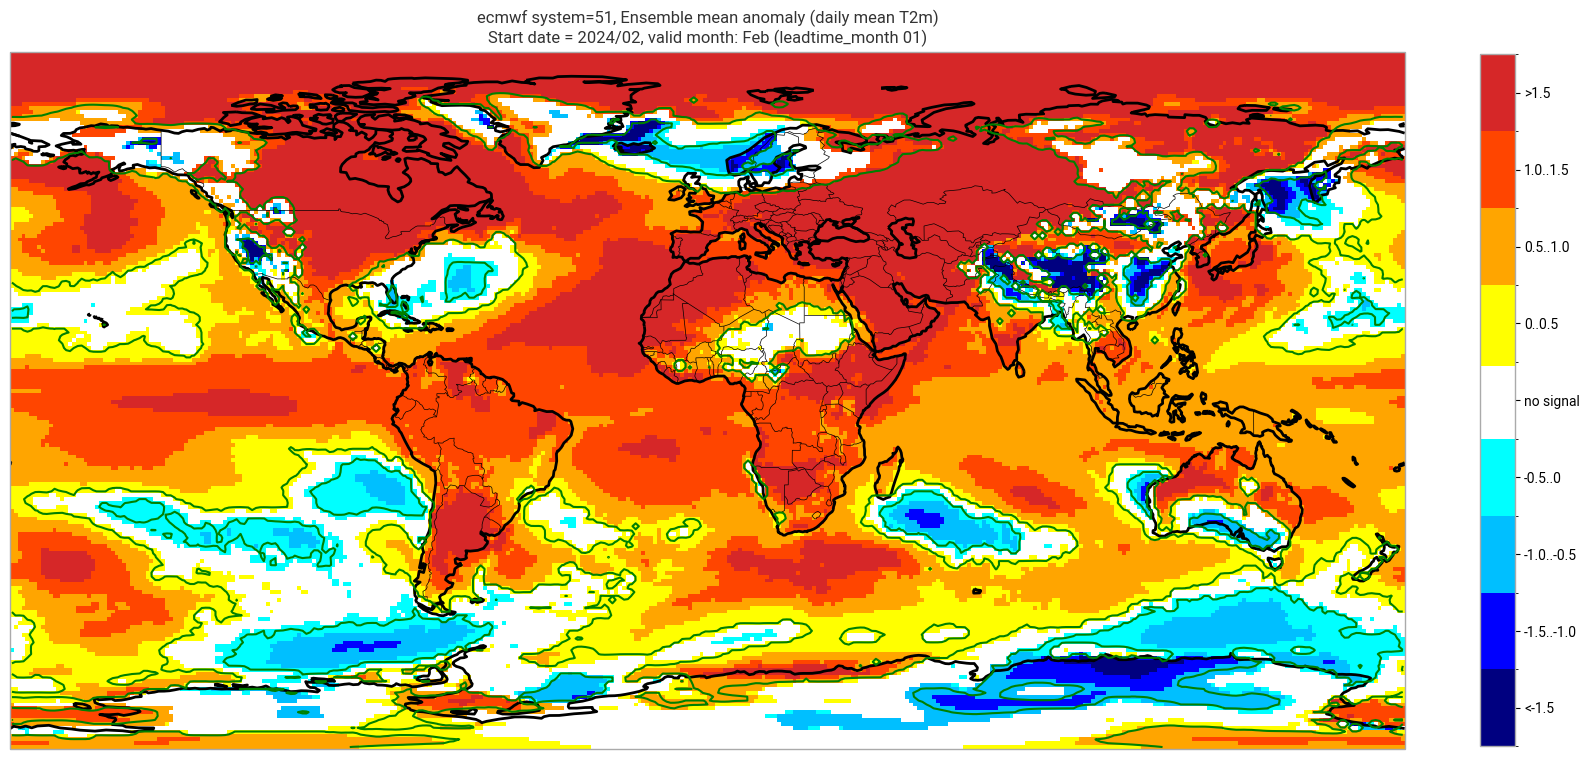

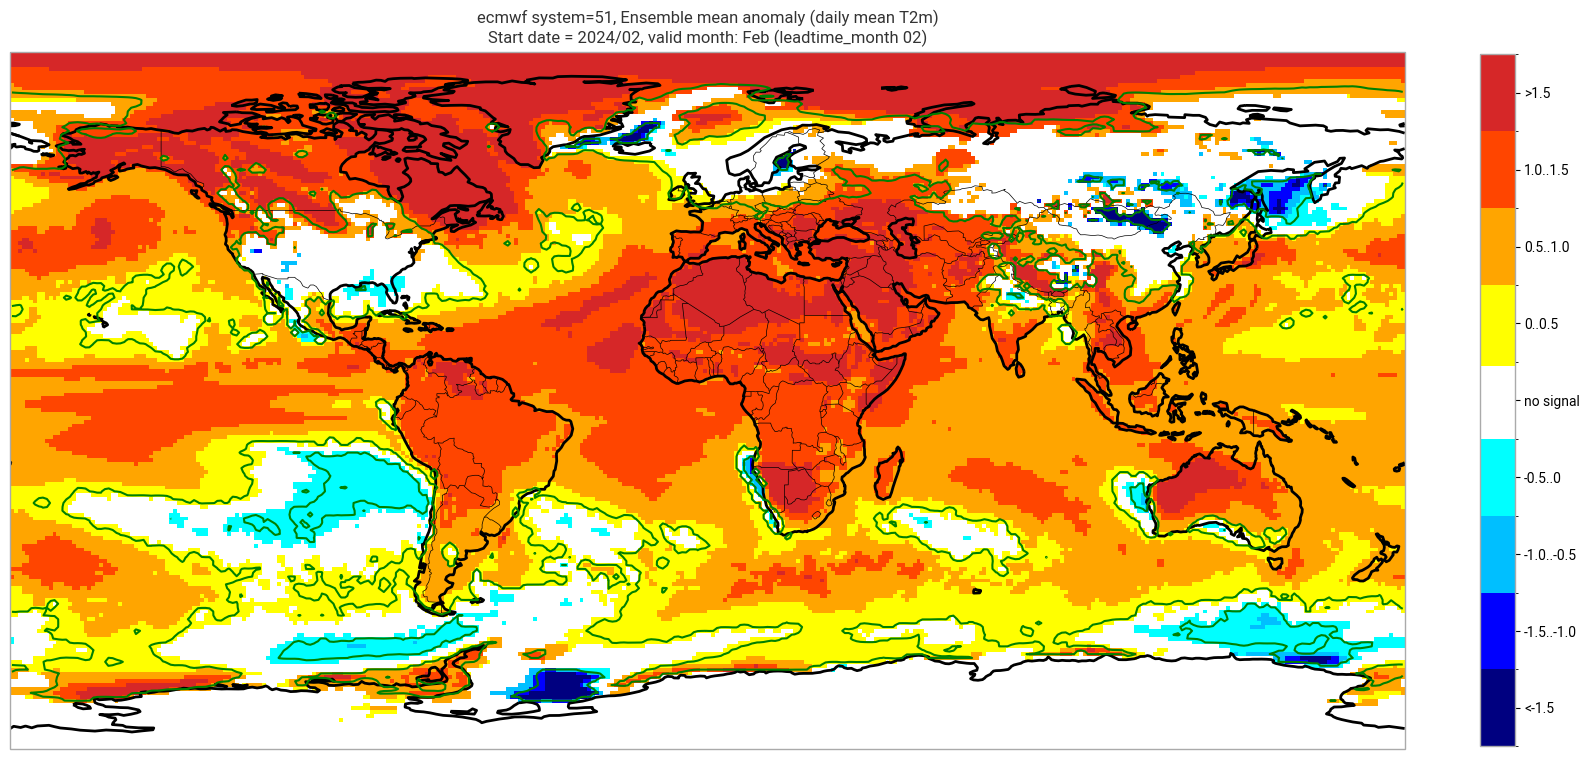

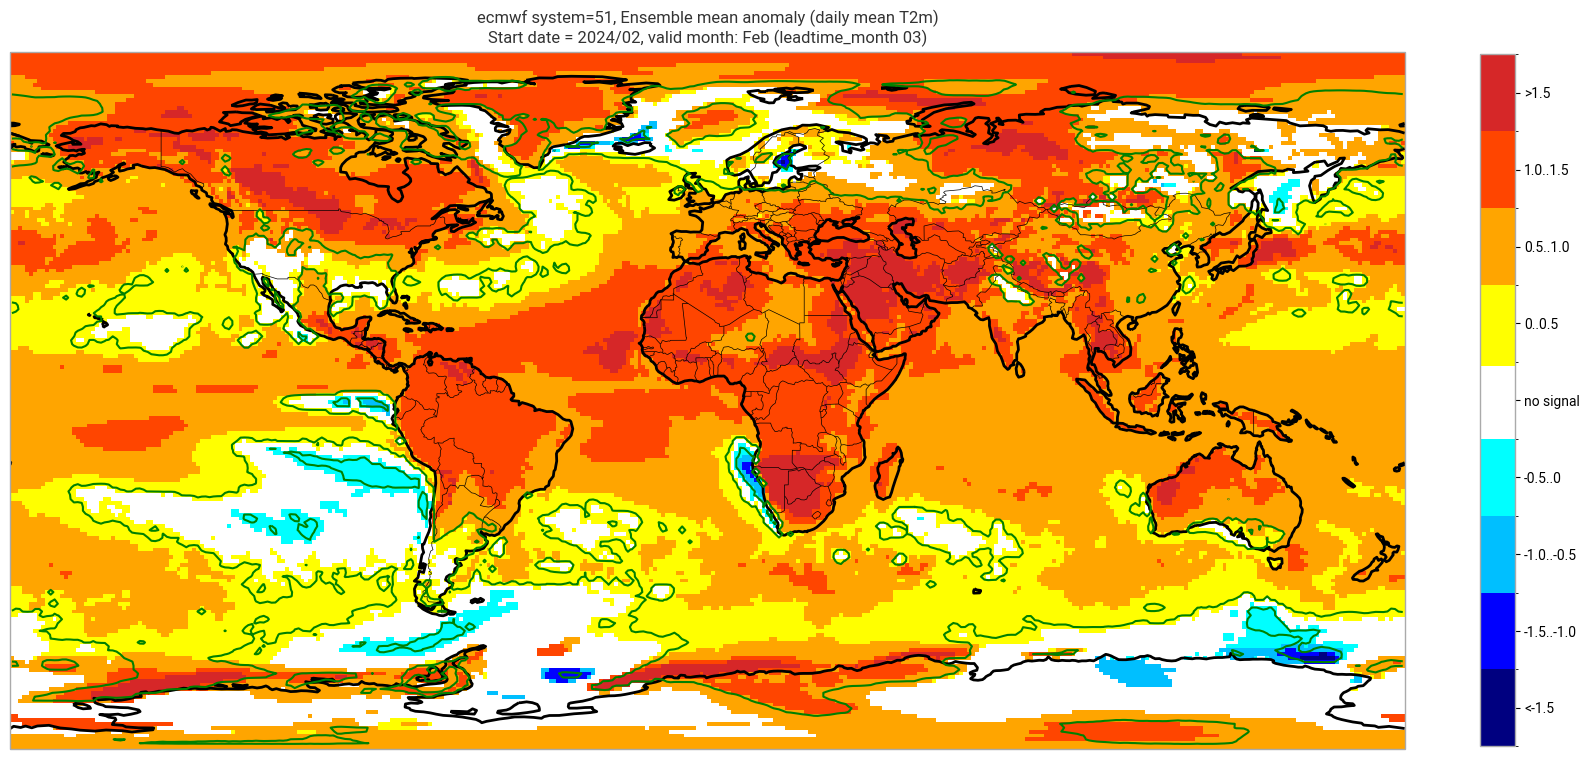

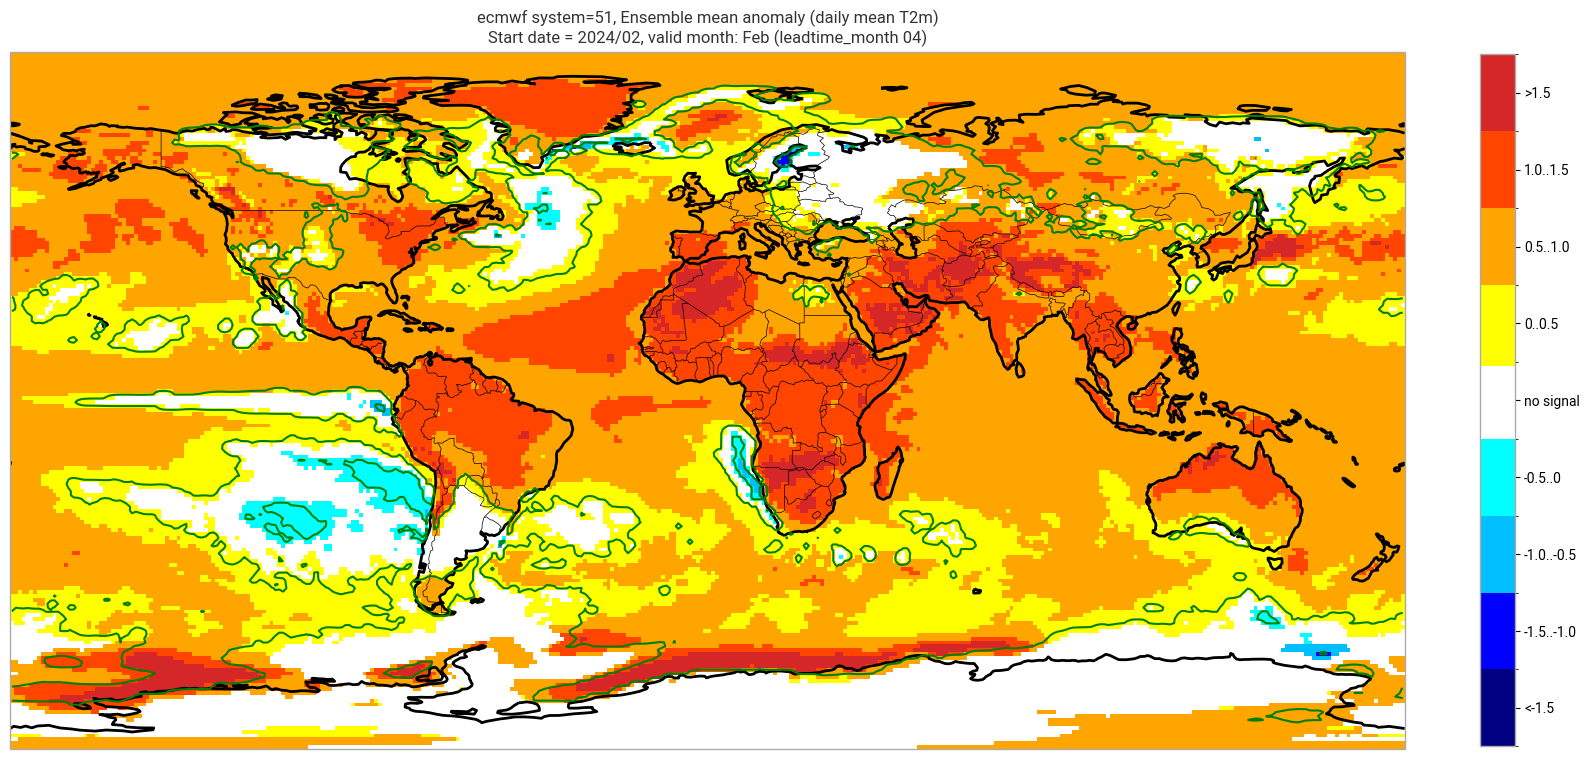

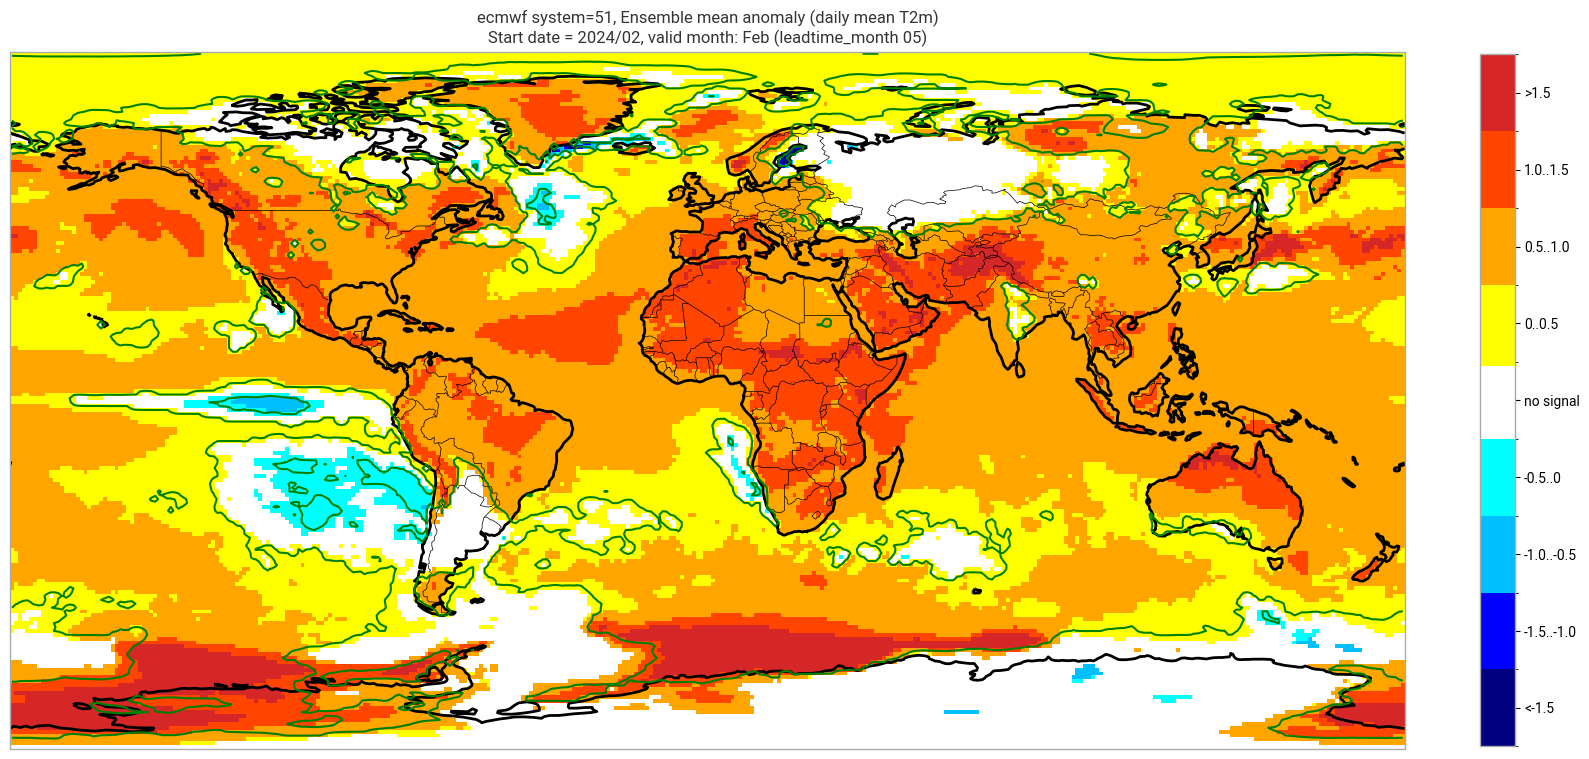

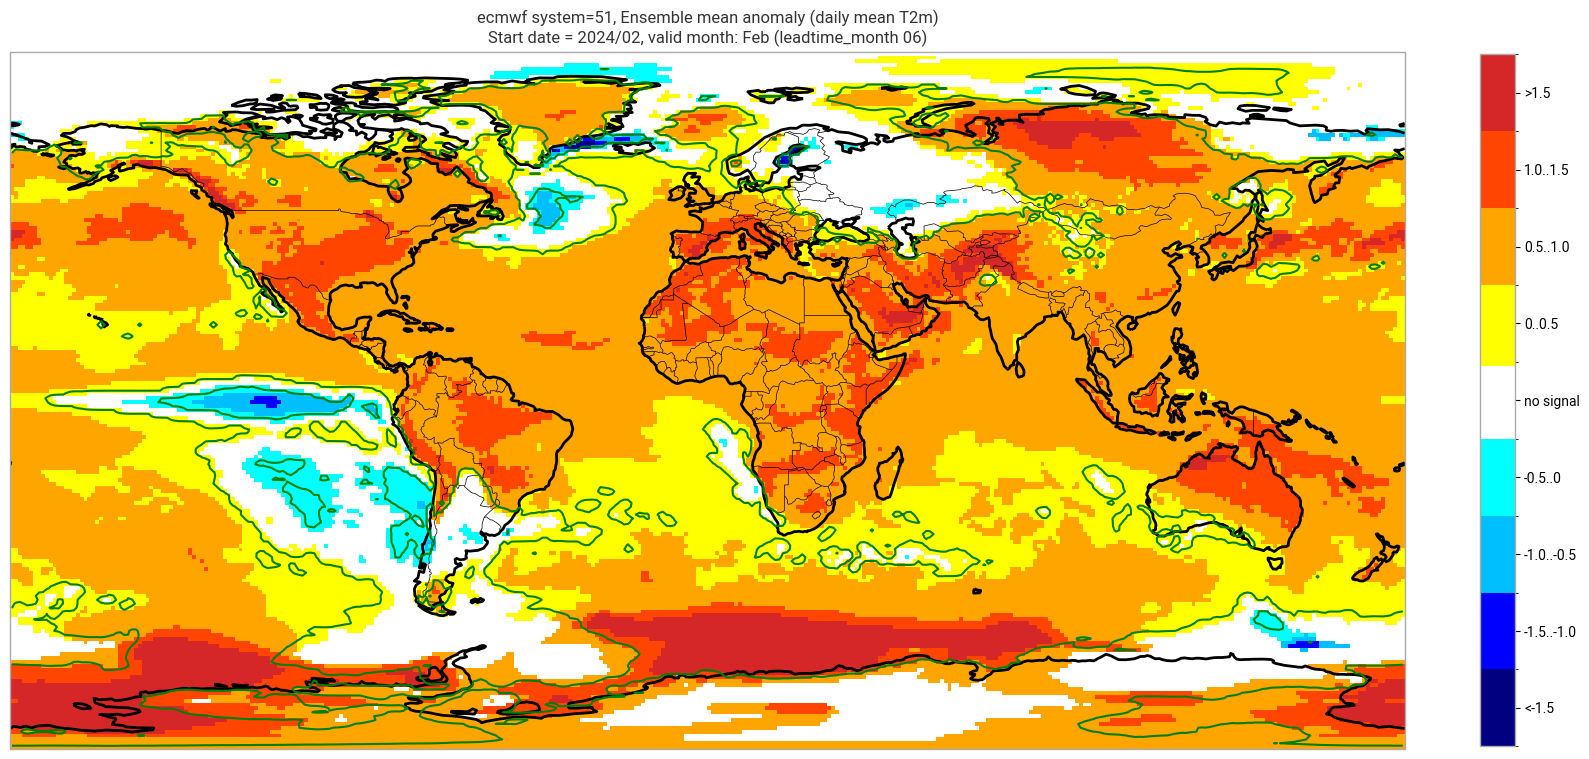

In [22]:
# Import function for non-paired rank-sum test
from scipy.stats import mannwhitneyu

# Significance thresholds
pval_thresh_low = 0.1
pval_thresh_high = 0.01

for ltm in lt_mons:
    
    data1 = hcst.sel(forecastMonth=ltm)
    data2 = fcst.sel(forecastMonth=ltm)
 
    # need to flatten number and start date to 'samples'
    # proceed in numpy for simplicity
    data1 = data1.data  # includes member and start date
    data2 = data2.data  # includes member

    # flatten sample dimensions
    data1 = data1.reshape(-1, *data1.shape[-2:])  # lat lon are the last dimensions
    print('Flattened forecasts: ', data1.shape)

    # non-paired approach, need to use Mann–Whitney U test
    pvals2 = mannwhitneyu(data1, data2)
    pvals2.pvalue
    
    masked_anom_mean = fcst_anom_mean.sel(forecastMonth=ltm).where(pvals2.pvalue <= 0.1)

    # specific values for Tmax, adjusted to add a dummy white section to label as 'no signal'
    contour_levels = [-2., -1.5, -1., -0.5, -1e-15, 1e-15, 0.5, 1.0, 1.5, 2.0]  # dummy values to plot central white portion in colorbar
    cbar_colours = ["navy", "blue", "deepskyblue", "cyan", "white", "yellow", "orange", "orangered", "tab:red"]
    cbar_labels = ["<-1.5", "-1.5..-1.0", "-1.0..-0.5", "-0.5..0", "no signal", "0..0.5", "0.5..1.0", "1.0..1.5", ">1.5"]
    
    lt_str = str(ltm).zfill(2)
    valid_time = pd.to_datetime(plot_data.valid_time.values)
    vm_str = valid_time.strftime('%b')  # valid month string to label the plot
    title_txt1 = '{} system={}'.format(centre, version) + ', Ensemble mean anomaly ({})'.format(var_str)
    title_txt2 = 'Start date = {}/{}, valid month: {} (leadtime_month {})'.format(fc_yr, st_mon, vm_str, lt_str)
    print(title_txt1)
    print(title_txt2)

    fig = plt.figure(figsize=(16, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.)
    im = masked_anom_mean.plot(levels=contour_levels, colors=cbar_colours, add_colorbar=False)
    cbar = plt.colorbar(im, fraction=0.023, extend='neither', ticks=[-1.75, -1.25, -0.75, -0.25, 0, 0.25, 0.75, 1.25, 1.75])
    cbar.ax.set_yticklabels(cbar_labels)
    plt.contour(masked_anom_mean.lon.values, masked_anom_mean.lat.values, pvals2.pvalue, levels=[0.01], colors='green')
    plt.title(title_txt1 + '\n' + title_txt2)
    plt.tight_layout()